<h1 style="text-align: center; font-size: 30px;">HAM vs. SPAM Classification</h1>

<center><img src="https://miro.medium.com/v2/resize:fit:1105/1*nBgCTU_hAVG00eYkcRf6Mw.png" align="center" alt="Ham vs. Spam filtering image" style="width: 800px;"/><center>


<h1 style="text-align: center; font-size: 10px;">https://miro.medium.com/v2/resize:fit:1105/1*nBgCTU_hAVG00eYkcRf6Mw.png</h1>

### Using TF-IDF to assist with classifying emails
Sovann Chang

## Background

Ask anyone who actively uses email or texts how they feel about spam, and you are almost guaranteed to get a negative response every time. At its _best_, spam is a mild annoyance, cluttering up our inboxes and messages with useless garbage. At its worst, spam can lure in the vulnerable with enticing promises that mask the presence of a malicious scam. 

The very first spam email was sent in 1978, but the development of the internet in the 1990s is when spam really began to become common (1). 30 years later, spam has became so prevalent that our emails and messaging apps have filters to keep spam out. With the rise of generative AI models, spam and phishing emails seem set to become even more common and more difficult to identify (2). With this in mind, detecting spam will be even more important, and our methods for doing so will need to be sound.

So how do we distinguish spam emails from regular, or "ham", emails? As humans, there are many ways for us to visually identify spam, but most of them are easily countered by spammers who ensure that their emails look as normal as possile. When emails are passable visibly, all we have to work with is text. Any good automatic spam filter will need to parse the text of an email to determine its validity. It will need to learn to identify patterns in the text that are indicative of spam. The simplest form of this is to find words that are often used in spam emails but rarely used in legitimate emails. Luckily, there is a way to estimate this intangible quality for an individual word. 

#### TF-IDF

Term Frequency-Inverse Document Frequency, or TF-IDF, is a combination of two different measurements. Term Frequency represents how often a term appears in a document, calculated as the number of times a term appears divided by the number of terms in the document. Document Frequency is a representation of how common a term is in an entire corpus, calculated by dividing the number of documents in which the term appears by the total number of documents in the corpus. _Inverse_ Document Frequency is, in a sense, its opposite. It can be thought of as "How unique is this term to this document?", and is calculated by taking the reciprocal (numerator and denominator swap places) of Document Frequency and taking the natural log of the result. The Term Frequency and Inverse Document Frequency are then multiplied to yield TF-IDF.

Conceptually, this produces a combination of "How important is this word to this document?" and "How unique is this word to this document?". If a word is both fairly important and relatively unique to multiple spam documents, it is a good indicator of spam. For this reason, TF-IDF is a common method for spam detection.

We want to test the efficacy of TF-IDF on our dataset. Naturally, our first research question is as follows: **Can we train a logistic regression model to accurately classify spam emails using _only_ TF-IDF data?**

Our hypothesis is that we can do this, given that TF-IDF is commonly used as a part of classification. We believe that it will be sufficient to stand on its own.

In [1]:
# Import data manipulation, plotting, and NLP packages
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import words
import time

In [21]:
# Import modeling packages
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

When our data ready to be analyzed, we will use the spaCy package to process it.

In [2]:
nlp = spacy.load("en_core_web_sm")

## Data

The sample emails being used for this analysis are taken from a [Kaggle dataset](https://www.kaggle.com/datasets/meruvulikith/190k-spam-ham-email-dataset-for-classification/data) containing nearly 194,000 total ham and spam emails. The dataset is relatively clean and simple, containing just two variables: the text of the email and the spam/ham label. The author describes the dataset as a combination of multiple other datasets, although they do not list the other datasets. While we acknowledge that it is plausible that this data is substandard, emails come in all shapes and sizes, so most samples of emails can still be useful, even if they are not wholly representative of all emails.

In [3]:
emails = pd.read_csv("spam_Emails_data.csv").dropna().reset_index(drop=True)
emails

,label,text
0,Spam,viiiiiiagraaaa\nonly for the ones that want to...
1,Ham,got ice thought look az original message ice o...
2,Spam,yo ur wom an ne eds an escapenumber in ch ma n...
3,Spam,start increasing your odds of success & live s...
4,Ham,author jra date escapenumber escapenumber esca...
...,...,...
193845,Ham,on escapenumber escapenumber escapenumber rob ...
193846,Spam,we have everything you need escapelong cialesc...
193847,Ham,hi quick question say i have a date variable i...
193848,Spam,thank you for your loan request which we recie...


In [4]:
emails.text[193847]

"hi quick question say i have a date variable in a data frame or matrix and i'd like to preserve the date format when using write table however when i export the data i get the generic number underlying the date not the date per se and a number such as escapenumber escapenumber etc are not meaningful in excel is there any way i can preserve the format of a date on writing into a text file tia and best tir r help stat math ethz ch mailing list https stat ethz ch mailman listinfo r help please do read the posting guide http www r project org posting guide html and provide commented minimal self contained reproducible code "

After loading the data and examining a specific example, we notice a problem: some of the words in the emails were clearly not written by the sender. For example, "escapenumber" and "elem" sound like HTML or JavaScript tags for objects, which may be a text rendering of some visual aspect of the email. We may want to clean this, but we must first identify how common these invalid words are. We can use a Python Counter to retrieve a count of how many times each term appears throughout the corpus.

## Data Exploration and Cleaning

In [5]:
word_counts = Counter()

for email in emails.text:
    words_in_email = email.split()
    word_counts.update(words_in_email)

In [154]:
word_counts.most_common(40)

[('escapenumber', 3294103),
 ('the', 1299658),
 ('to', 892867),
 ('and', 657209),
 ('of', 619981),
 ('a', 546982),
 ('.', 452740),
 ('in', 448771),
 ('escapelong', 444599),
 ('-', 372678),
 ('for', 343997),
 (',', 334340),
 ('you', 316529),
 ('is', 316476),
 ('i', 257310),
 ('com', 256158),
 ('this', 248675),
 ('that', 246196),
 ('on', 245475),
 ('with', 197490),
 ('be', 195460),
 ('from', 184798),
 ('http', 184055),
 ('enron', 181720),
 ('it', 173581),
 ('your', 170912),
 ('as', 167220),
 ('/', 158525),
 ('or', 156814),
 ('are', 155071),
 ('have', 152009),
 ('at', 147812),
 (':', 146499),
 ('we', 138485),
 ('will', 136883),
 ('not', 136395),
 ('by', 133562),
 ('e', 124857),
 ('if', 116782),
 ('cescapenumber', 114879)]

Indeed, some very common "words" are clearly not actual words. "escapenumber" is nearly three times as common as any other term, and "escapelong" and "cescapenumber" also are present in the top 40. How can we filter these terms out? The nltk package gives us some options. It contains two packages that may help us here. wordnet was created by Princeton, and is a large lexical database of English nouns, verbs, adjectives, and adverbs (3). nltk.corpus contains "words", a standard dictionary of words recognized by Unix systems (4). 

In [7]:
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sovann\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Sovann\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [8]:
english_words = set(words.words())

In [162]:
list(english_words)[0:5]

['unbalanceable', 'extrasomatic', 'indexed', 'semijudicial', 'helplessness']

wordnet and Unix words are good for different things, as shown below. "bible" is recognized by wordnet but not the Unix words, while "for" is recognized by Unix but not wordnet. We can try combining the two to cover as many words as possible.

In [10]:
wn.synsets("bible")

[Synset('bible.n.01'), Synset('bible.n.02')]

In [11]:
"bible" in english_words

False

In [12]:
wn.synsets("for")

[]

In [13]:
"for" in english_words

True

We test the combination of wordnet and Unix words by printing out the first 20 words that appear that are in neither set.

In [164]:
printed = 0
for word, count in word_counts.items():
    if not (word in english_words or wn.synsets(word)):
        if printed < 20:
            print(word)
        printed += 1

viiiiiiagraaaa
.
moiseyev
bernie
angeles
gerry
bayreuth
tuttle
itt
caan
'
mailto
iceoperations
intcx
com
escapenumber
escapelong
intercontinentals
wom
ch


The combination seems to do a pretty good job. The only word out of the 20 that should probably be valid is Angeles, and that might only be invalid because of the lowercase 'a'. This brings up an interesting thought: misspelled words could themselves be a sign of spam. We may want to keep track of percentage of invalid words detected in each email to answer our second research question: **Can calculating the rate of misspelled or otherwise invalid words contribute to identifying spam?**

Our hypothesis for this research question is that a high rate of misspelled words will be a sign of a spam email, and that using this rate as a feature can positively affect a model's performance to a noticeable degree.

We define a function in order to clean the data and extract the rates of these invalid words.

In [15]:
def clean_text(text, vocabulary):
    # NLP limits text to 100K characters
    if len(text) > 100000:
        text = text[0:100000]
        
    word_list = text.split()
    
    invalid_words = 0
    valid_words = []
    
    for word in word_list:
        if word in vocabulary or wn.synsets(word):
            valid_words.append(word)
        else:
            invalid_words += 1
            
    cleaned_text = ' '.join(valid_words)
    return cleaned_text, invalid_words / len(word_list)

In [16]:
clean_text(emails.loc[0, "text"], english_words)

('only for the ones that want to make her scream prodigy scrawny crow define upgrade spongy balboa dither schumann variegate ponce cox impassive circulate impend miscellany chalkboard whizzing pend armenian cutlet waring makeshift fletch dispel crest cadet dovetail rapprochement selectman wilmington alchemy bullyboy t do',
 0.25)

After timing a test run, NLP on the first 10,000 emails took more than 10 minutes. For the sake of ensuring that everything takes a reasonable amount of time, we'll randomly sample 20,000 of our emails (around 10% of the total emails in the dataset) and use that as our new dataset.

In [17]:
emails = emails.sample(n=20000, random_state=42).reset_index(drop=True)
emails

,label,text
0,Ham,ets intranet consolidation project updates ( w...
1,Ham,article written tamim ansary afghani american ...
2,Ham,kevin attached electricity price discovery res...
3,Ham,cnat calm possible sir original message maggi ...
4,Ham,there are now two house hearnigs tomorrow not ...
...,...,...
19995,Spam,tramadol hydrochloride tablets help relieve di...
19996,Spam,access all the popular software imaginable for...
19997,Ham,see attached draft memo that outlines certain ...
19998,Spam,floor the physical mouth a advertisement be co...


In [18]:
emails["label"].value_counts()

Ham     10429
Spam     9571
Name: label, dtype: int64

We have a fairly even split between ham and spam emails, with 52.1% ham and 47.9% spam. Now, we want to run our cleaning function on the dataframe and create new columns for cleaned text and invalid word percentage.

In [19]:
# Creating new columns for invalid word percentage and cleaned text
emails["invalid_pct"] = 0
emails["cleaned_text"] = ""

# Running the clean_text function on each email and saving the output in the new columns
for i in range(len(emails)):
    email_text = emails.loc[i, "text"]
    cleaned_text, invalid = clean_text(emails.loc[i, "text"], english_words)
    
    emails.loc[i, "cleaned_text"] = cleaned_text
    emails.loc[i, "invalid_pct"] = invalid

In [20]:
cleaned_emails = emails[["cleaned_text", "invalid_pct", "label"]]
cleaned_emails

,cleaned_text,invalid_pct,label
0,intranet consolidation project updates www wha...,0.377622,Ham
1,article written afghani american writer take a...,0.033557,Ham
2,attached electricity price discovery results f...,0.381818,Ham
3,calm possible sir original message mike sent t...,0.245283,Ham
4,there are now two house tomorrow not just one ...,0.101190,Ham
...,...,...,...
19995,hydrochloride tablets help relieve different t...,0.166667,Spam
19996,access all the popular software imaginable for...,0.349315,Spam
19997,see attached draft memo that outlines certain ...,0.424354,Ham
19998,floor the physical mouth a advertisement be co...,0.040268,Spam


This will be used as our final data for analysis

## NLP

The first step in the analysis is to run NLP on the cleaned text. Because this will be slow, we have timed the process and printed the number of seconds that it took below.

In [24]:
start = time.time()
email_docs = list(nlp.pipe(cleaned_emails.cleaned_text))
end = time.time()
end - start

1095.389024734497

After nearly 20 minutes, NLP is complete and we are ready for the next step.

## Modeling

We will be using the TfidfVectorizer function from sklearn.feature_extraction to perform TF-IDF. This function allows for a custom-defined tokenizer, which is where we will take advantage of our spaCy NLP representations. We first define a tokenizer that will remove periods and spaces from the text, then remove stop words. Stop words are words that are commonly used in English, but do not provide much information. Examples include determiners like "the" and "a" as well as prepositions like "his" and "her".They are removed from text before performing many NLP tasks because they can affect the outcome in ways that do not reflect reality. For example, if two texts are analyzed for similarity and both texts contain many of these stop words, they will likely be considered similar simply because they both use words like "the" or "his", even if the remainder of the content of the texts has nothing in common. Removing stop words is a standard practice in NLP (5).

In [25]:
stop_words = STOP_WORDS

def tokenize_docs(doc):
    tokens = [tok.lemma_.lower() for tok in doc if not tok.is_punct and not tok.is_space]
    return [tok for tok in tokens if tok not in stop_words]

We are ready to define our TF-IDF vectorizer and fit it to the emails.

In [122]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_docs, token_pattern=None, lowercase=False, min_df=5)

In [123]:
vec = tfidf_vectorizer.fit_transform(email_docs)

Now that our vectorizer is fit to the data, we can extract the terms that are represented by each column and view the TF-IDF values for each word/document combination.

In [124]:
tfidf_df = pd.DataFrame(vec.todense())
tfidf_df.columns = tfidf_vectorizer.get_feature_names_out()
tfidf_df["ham_label"] = cleaned_emails.label.values
tfidf_df["ham_label"] = (tfidf_df["ham_label"] != "Ham").astype("int")
tfidf_df

,0,1,10,100,1000,101,105,10th,11,110,...,zoloft,zombie,zonal,zone,zoo,zoom,zs,zu,zurich,ham_label
0,0.0,0.05951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
19996,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
19997,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
19998,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Now that our TF-IDF is done, we can train a logistic regression model on the TF-IDF data. We first split the 20,000 rows into a training and testing dataset, then separate the ham_label column from the TF-IDF columns.

In [125]:
classifier = LogisticRegression()

train, test = train_test_split(tfidf_df, test_size=0.2, random_state=42, stratify=tfidf_df["ham_label"])

In [126]:
X_train = train.drop(columns=["ham_label"])
y_train = train["ham_label"]

X_test = test.drop(columns=["ham_label"])
y_test = test["ham_label"]

In [127]:
y_test

6056     1
13603    0
1226     1
2589     0
18355    0
        ..
10444    0
13674    1
15050    1
1833     0
15123    1
Name: ham_label, Length: 4000, dtype: int32

Our data is split into training and testing, so we can fit the regression model to the training data.

In [128]:
classifier.fit(X_train, y_train)

LogisticRegression()

##### Testing and Evaluation

We are ready to make predictions and evaluate our model's performance.

In [129]:
predicted = classifier.predict(X_test)

In [130]:
metrics.accuracy_score(y_test, predicted)

0.949

In [131]:
metrics.precision_score(y_test, predicted)

0.9357798165137615

In [132]:
metrics.recall_score(y_test, predicted)

0.9592476489028213

Our first result is pure accuracy, calculated as the number of correctly classified documents divided by the total number of documents.

The second result is precision. Precision can be thought of as "when we predict spam, how accurate are we?" It is calculated by dividing the number of True Positives (predicted spam AND actually is spam) by the number of predicted positives (predicted spam regardless of actual value).

The third result is recall. Recall can be thought of as "how good are we at identifying spam?" It is calculated by dividing the number of True Positives (predicted spam AND actually is spam) by the number of actual positives (actaually is spam regardless of prediction.


Below, we visualize our accuracy in predicions using a heatmap.

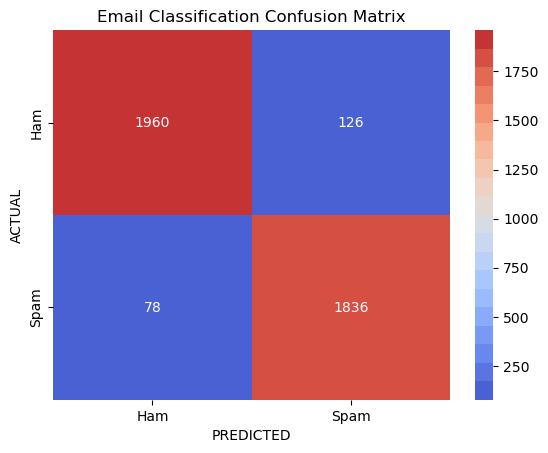

In [133]:
cm = metrics.confusion_matrix(y_test, predicted)
sns.heatmap(cm, annot=True, fmt='d', cmap = sns.color_palette("coolwarm", 20), xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.title('Email Classification Confusion Matrix')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.show()

#### Conclusion 1

These results are quite good! Using only TF-IDF, we were able to classify emails with 94.9% accuracy. Our precision and recall scores are quite high as well, signifying that we are able to minimize both false positives and false negatives, which is also indicative of a good model. With this in mind, we can say that our hypothesis for the first research question is accurate - <u>we can effectively classify ham and spam documents using TF-IDF.</u>

One nice thing about this method we used is that we can view the coefficients of each word to see which words are most indicative of ham or spam.

In [134]:
vocab = list(pd.DataFrame(tfidf_vectorizer.vocabulary_, index=[0]).T.sort_values(0).index)
coefficients = pd.DataFrame({'coefficients':list(classifier.coef_.flatten()), 'word': vocab})
coefficients

,coefficients,word
0,0.645761,0
1,-0.208148,1
2,-0.446985,10
3,0.861631,100
4,0.295407,1000
...,...,...
14596,-0.136908,zoo
14597,0.153178,zoom
14598,0.240017,zs
14599,0.589116,zu


We are interested in discovering which words are most indicative of ham and spam respectively. We can retrieve the 25 most positive and negative coefficients to see this.

In [135]:
# Get the 25 most influential negative coefficients
lowest = coefficients.sort_values(by='coefficients').head(25).reset_index(drop=True)
lowest.columns = ["coefficient_low", "ham_indicator"]

# Get the 25 most influential positive coefficients
highest = coefficients.sort_values(by='coefficients', ascending=False).head(25).reset_index(drop=True)
highest.columns = ["coefficient_high", "spam_indicator"]

# Combine the negative and positive coefficients into one dataframe
most_important_words = pd.concat([lowest, highest], axis=1)

In [136]:
most_important_words

,coefficient_low,ham_indicator,coefficient_high,spam_indicator
0,-5.571765,thank,3.145960,product
1,-4.881100,subject,3.135748,http
2,-4.643366,samba,3.034440,target
3,-4.547830,attach,2.950950,save
4,-4.258213,question,2.898979,money
5,-3.962508,comment,2.826852,remove
6,-3.827366,houston,2.776149,offer
7,-3.686493,pm,2.681395,account
8,-3.488709,send,2.536901,price
9,-3.400850,fax,2.503136,hot


Many of these results make intuitive sense. Words such as "question", "comment", and "meeting" are highly indicative of real emails. Most spam emails would not try to ask questions, make comments, or schedule meetings. On the other hand, spam is suggested with words like "product", "pill", and "save", words that are associated with trying to sell someone something.

##### Including invalid word rates

To address our second research question, we rerun out model, this time including the percentage of invalid words in each email.

In [137]:
tfidf_df["invalid_pct"] = cleaned_emails.invalid_pct.values
tfidf_df

,0,1,10,100,1000,101,105,10th,11,110,...,zombie,zonal,zone,zoo,zoom,zs,zu,zurich,ham_label,invalid_pct
0,0.0,0.05951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.377622
1,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.033557
2,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.381818
3,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.245283
4,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.101190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.166667
19996,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.349315
19997,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.424354
19998,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.040268


In [138]:
classifier2 = LogisticRegression()

train_inv, test_inv = train_test_split(tfidf_df, test_size=0.2, random_state=42, stratify=tfidf_df["ham_label"])

In [139]:
X_train_inv = train_inv.drop(columns=["ham_label"])
y_train_inv = train_inv["ham_label"]

X_test_inv = test_inv.drop(columns=["ham_label"])
y_test_inv = test_inv["ham_label"]

In [140]:
classifier2.fit(X_train_inv, y_train_inv)

LogisticRegression()

In [142]:
predicted_inv = classifier2.predict(X_test_inv)

In [143]:
metrics.accuracy_score(y_test_inv, predicted_inv)

0.94925

In [144]:
metrics.precision_score(y_test_inv, predicted_inv)

0.9393939393939394

In [145]:
metrics.recall_score(y_test_inv, predicted_inv)

0.9555903866248694

Our results are very similar to the model without using invalid word rates, with only a very slight increase in accuracy and precision, but a slight decrease in recall. The heatmap shows that the two models are very similar in performance.

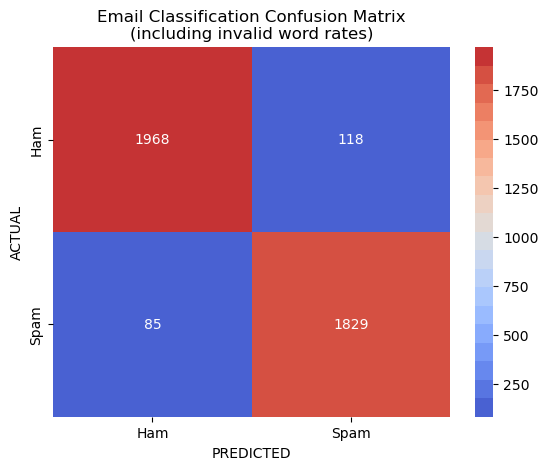

In [146]:
cm = metrics.confusion_matrix(y_test_inv, predicted_inv)
sns.heatmap(cm, annot=True, fmt='d', cmap = sns.color_palette("coolwarm", 20), xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.title('Email Classification Confusion Matrix\n(including invalid word rates)')
plt.xlabel('PREDICTED')
plt.ylabel('ACTUAL')
plt.show()

We again aim to get the 25 best words for indicating ham and spam.

In [147]:
vocab.append("invalid_pct")
coefficients_inv = pd.DataFrame({'coefficients':list(classifier2.coef_.flatten()), 'word': vocab})
coefficients_inv

,coefficients,word
0,0.514852,0
1,-0.482971,1
2,-0.607172,10
3,0.776932,100
4,0.251322,1000
...,...,...
14597,0.154439,zoom
14598,0.213791,zs
14599,0.415764,zu
14600,-0.005588,zurich


In [148]:
# Get the 25 most influential negative coefficients
lowest_inv = coefficients_inv.sort_values(by='coefficients').head(25).reset_index(drop=True)
lowest_inv.columns = ["coefficient_low", "ham_indicator"]

# Get the 25 most influential positive coefficients
highest_inv = coefficients_inv.sort_values(by='coefficients', ascending=False).head(25).reset_index(drop=True)
highest_inv.columns = ["coefficient_high", "spam_indicator"]

# Combine the negative and positive coefficients into one dataframe
most_important_words_inv = pd.concat([lowest_inv, highest_inv], axis=1)

In [149]:
most_important_words_inv

,coefficient_low,ham_indicator,coefficient_high,spam_indicator
0,-5.232343,thank,3.321853,product
1,-4.911143,subject,3.015878,save
2,-4.777585,samba,3.009436,target
3,-4.219035,attach,2.968754,money
4,-4.052739,question,2.944193,offer
5,-3.893255,pm,2.933500,remove
6,-3.887827,comment,2.859142,http
7,-3.856273,houston,2.780172,account
8,-3.705802,fax,2.664695,hot
9,-3.478917,corp,2.544347,info


This time, we also want to see how influential our invalid_pct variable is.

In [150]:
coefficients_inv[coefficients_inv["word"] == "invalid_pct"]

,coefficients,word
14601,1.781611,invalid_pct


#### Conclusion 2

Given the results of this new model, we can see that invalid_pct is indeed indicative of spam, and carries a relatively positive coefficient. However, the performance of the model is very similar. Therefore, our second hypothesis was half right: invalid word percentage _is_ indicative of spam emails, but including it as a feature does _not_ noticeably improve the model.

### References

1. https://www.britannica.com/topic/spam
2. https://www.cnbc.com/2023/11/28/ai-like-chatgpt-is-creating-huge-increase-in-malicious-phishing-email.html
3. https://wordnet.princeton.edu/
4. https://github.com/nltk/nltk_data/blob/gh-pages/packages/corpora/words.xml
5. https://kavita-ganesan.com/what-are-stop-words/